# Start Up

Upload the modules

In [1]:
%pip install pandas
%pip install numpy
%pip install -U matplotlib
%pip install scipy
%pip install math
%pip install openpyxl
%pip install scikit-learn
%pip install SALib
%pip install pyDOE
%pip install h5py


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import math as math
import os 
import warnings
from sklearn.metrics import r2_score 
import copy
import subprocess
from PIL import Image
import scipy.stats as stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
import json
import datetime
from scipy.stats import t
from pyDOE import lhs
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit, minimize
import math as math
import os 
import warnings
import copy
import subprocess
from PIL import Image
from scipy.optimize import approx_fprime
import importlib
import textwrap
import sys




Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement math (from versions: none)
ERROR: No matching distribution found for math


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import functions_fitting
from functions_fitting import *
importlib.reload(functions_fitting)

import fitting_inputs
from fitting_inputs import *
importlib.reload(fitting_inputs)

#Make sure the right dataset is loaded
data = np.load('./data_reading/arrays_2024_10_24_15_25.npz')
array_names = data.files  # This returns a list of names
for name in array_names:
    globals()[name] = data[name]

# Flow Curves: Compare Stress Growth and LAOS and HB Fitting

Steady fitted HB: TAU - n - dotgammacr : [8.47402959e+02 2.86646068e-01 1.35690662e-01]
External HB: TAU - n - dotgammacr : [1.e+03 2.e-01 1.e+01]


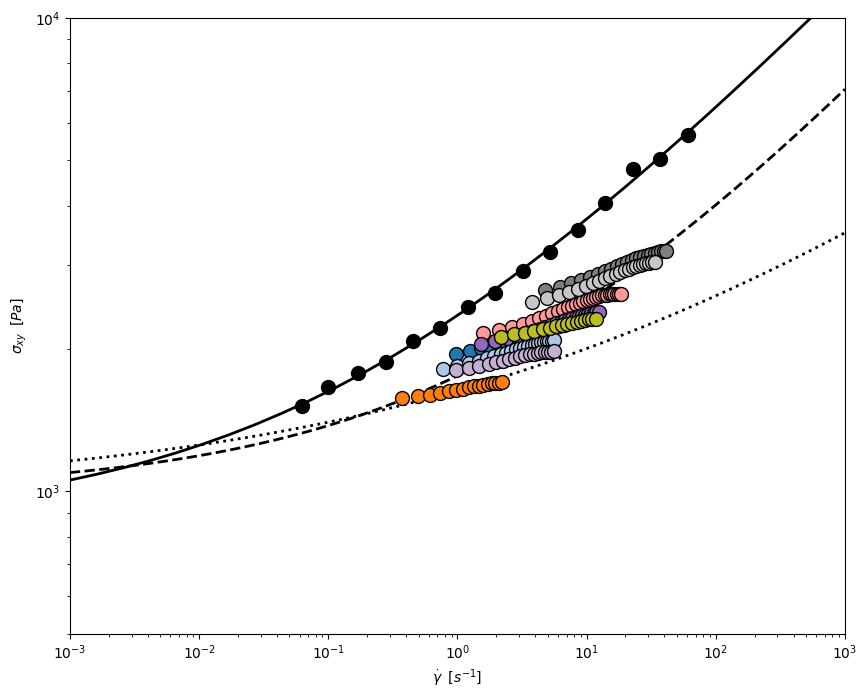

In [3]:
if run_HB == 'yes':

    #Create teh array for checkpoint
    write_out = []

    # Figure settings
    fig, axs = plt.subplots(figsize=(10, 8))
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_xlim(0.001,1000)
    axs.set_ylim(500,10000)
    axs.set_xlabel("$\dot{{\gamma}}\;\;[s^{-1}]$")
    axs.set_ylabel("$\sigma_{xy}\;\;[Pa]$")

    #Extract Herschel Bulkley parameters from Stress Growth data
    if extract_HB_param_from_stress_growth == 'yes':
        
        #plot the data
        stress, indexes = shear_rate_sweep(target_strain, data_exp_stgrw_avg, i_strain=i_strain, i_stress=i_stress)
        axs.errorbar(str_grw_shear_rates, stress, marker='o', linewidth=0, markersize = markersize, color='black', markeredgecolor='black', label='stress_growth' )
        
        #fit the data to the HB model
        popt_steady, pconv_steady = curve_fit(HB, str_grw_shear_rates, stress, p0=[1000, 10, 0.2] )
        dot_gammacr_steady = (popt_steady[0] / (popt_steady[1]))**(1/popt_steady[2])
        HBparam_steady = [popt_steady[0],  popt_steady[2], dot_gammacr_steady]
        
        #extract the parameters and plot the model
        model_data_HB_steady = HB(np.logspace(-3,5,40), popt_steady[0],popt_steady[1],popt_steady[2])
        plt.errorbar(np.logspace(-3,5,40),model_data_HB_steady,  linewidth=2, color='black')
        
        #calculate errors
        perr_steady = np.sqrt(np.diag(pconv_steady))
        HBst_dotgam_pluserr = (popt_steady[0] / (popt_steady[1]+perr_steady[1]))**(1/popt_steady[2])
        HBst_dotgam_minuserr = (popt_steady[0] / (popt_steady[1]-perr_steady[1]))**(1/popt_steady[2])
        error_HBsteady = [perr_steady[0], perr_steady[2], HBst_dotgam_pluserr, HBst_dotgam_minuserr]

        print(f'LAOS fitted HB: TAU - n - dotgammacr : {HBparam_steady}')
        
        #what to write in the checkpoint file?
        write_out_elements = ['HBparam_steady', 'error_HBsteady', 'model_data_HB_steady', 'stress', 'str_grw_shear_rates']
        for elem in write_out_elements:
            write_out.append(elem)


    if extract_HB_param_from_laos == 'yes':
        
        #Extract the portion of the data for the steady shear curve build and plot it
        x_shr,y_str = extract_steady_from_laos(data_exp_avg, nelements_cycle,\
                                               col_index_shearrate=col_index_shearrate, col_index_stress=col_index_stress)
        hbfit_x = []
        hbfit_y = []
        skip_first = 3
        for i in data_index_for_laos_built_flow_curves: 
            x = x_shr[i][skip_first:] ; y=y_str[i][skip_first:]
            axs.errorbar(x, y, marker='o', linewidth=0, markersize = markersize, color=color_palette[i],\
                        markeredgecolor='black' )
            for elem in x_shr[i][skip_first:]: hbfit_x.append(elem)
            for elem in y_str[i][skip_first:]: hbfit_y.append(elem)

        #fit the data to the HB model
        popt_laos, pconv_laos= curve_fit(HB, hbfit_x, hbfit_y, p0=[1000, 5, 0.2])
        dot_gammacr_laos = (popt_laos[0] / (popt_laos[1]))**(1/popt_laos[2])
        model_data_HB_laos = HB(np.logspace(-3,3,50), popt_laos[0],popt_laos[1],popt_laos[2])
        plt.plot(np.logspace(-3,3,50), model_data_HB_laos,  linewidth=2, color='black', linestyle='--')
        HBparam_laos = [popt_laos[0], popt_laos[2],  dot_gammacr_laos]

        #calcualte errors 
        perr_laos = np.sqrt(np.diag(pconv_laos))
        HBlaos_dotgam_pluserr = (popt_laos[0] / (popt_laos[1]+perr_laos[1]))**(1/popt_laos[2])
        HBlaos_dotgam_minuserr = (popt_laos[0] / (popt_laos[1]-perr_laos[1]))**(1/popt_laos[2])
        error_HBlaos = [perr_laos[0], perr_laos[2], HBlaos_dotgam_pluserr, HBlaos_dotgam_minuserr]
        
        print(f'LAOS fitted HB: TAU - n - dotgammacr : {HBparam_laos}')
        
        #what to write in the checkpoint file?
        x_shr = np.array(x_shr, dtype=object)
        y_str = np.array(y_str, dtype=object)
        write_out_elements = ['HBparam_laos', 'error_HBlaos', 'model_data_HB_laos',\
                               'x_shr', 'y_str', 'data_index_for_laos_built_flow_curves']
        for elem in write_out_elements:
            write_out.append(elem)


    if extract_HB_param_from_external == 'yes':
        HB_external_params = HB_external_params
        HBparam_ext = [HB_external_params[0], HB_external_params[2], HB_external_params[1]]
        error_HBext = error_HBext
        K_from_dotgamcr = HB_external_params[0] / (HB_external_params[1]**HB_external_params[2])
        model_data_HB_ext = HB(np.logspace(-3,3,50), HB_external_params[0],K_from_dotgamcr,HB_external_params[2])
        plt.plot(np.logspace(-3,3,50), model_data_HB_ext,  linewidth=2, color='black', linestyle=':')
        print(f'External HB: TAU - n - dotgammacr : {HBparam_ext}')
        write_out_elements = ['HBparam_ext', 'error_HBext', 'model_data_HB_ext']
        for elem in write_out_elements:
            write_out.append(elem)


    # Open a new file to store variables
    with open(f'checkpoints/HBfit_{formatted_time}_humanreadable.npz', 'w') as f:
        for var_name in dir():
            # Skip private/internal variables
            if not var_name.startswith('_'):
                var_value = eval(var_name)
                
                # Check if the variable is a NumPy array (or any other array-like type)
                if isinstance(var_value, (np.ndarray, list)):

                    if var_name in write_out:
                        # Write variable assignment to the file
                        text1 = f'{var_name} = {repr(var_value)}'
                        f.write(textwrap.fill(text1, width=80))
                        f.write('\n')

    np.savez(f'checkpoints/HBfit_{formatted_time}.npz', **{name: eval(name) for name in write_out})

elif run_HB == 'no':

    #Load the data
    data = np.load(F'./checkpoints/{readHB}.npz', allow_pickle=True)
    array_names = data.files  # This returns a list of names
    for name in array_names:
        globals()[name] = data[name]

    # Figure settings
    fig, axs = plt.subplots(figsize=(10, 8))
    axs.set_xscale('log')
    axs.set_yscale('log')
    axs.set_xlim(0.001,1000)
    axs.set_ylim(500,10000)
    axs.set_xlabel("$\dot{{\gamma}}\;\;[s^{-1}]$")
    axs.set_ylabel("$\sigma_{xy}\;\;[Pa]$")

    #Stress Growth
    if 'HBparam_steady' in globals():
        axs.errorbar(str_grw_shear_rates, stress, marker='o', linewidth=0, markersize = markersize, color='black', markeredgecolor='black', label='stress_growth' )
        plt.errorbar(np.logspace(-3,5,40),model_data_HB_steady,  linewidth=2, color='black')
        print(f'Steady fitted HB: TAU - n - dotgammacr : {HBparam_steady}')
    else:
        print('The stress growth infromation is not found in the file, taek action if you think this is wrong')

    #LAOS
    if 'HBparam_laos' in globals():
        for i in data_index_for_laos_built_flow_curves: 
            x = x_shr[i][skip_first:] ; y=y_str[i][skip_first:]
            axs.errorbar(x, y, marker='o', linewidth=0, markersize = markersize, color=color_palette[i],\
                        markeredgecolor='black' )
        plt.plot(np.logspace(-3,3,50), model_data_HB_laos,  linewidth=2, color='black', linestyle='--')
    else:
        print('The LAOS flow curve infromation is not found in the file, taek action if you think this is wrong')

    #External
    if 'HBparam_ext' in globals():
        plt.plot(np.logspace(-3,3,50), model_data_HB_ext,  linewidth=2, color='black', linestyle=':')
        print(f'External HB: TAU - n - dotgammacr : {HBparam_ext}')
    else:
        print('The external flow curve infromation is not found in the file, taek action if you think this is wrong')


# SAOS Fitting 

In [4]:
print(len(data_exp_frswp_waveform_avg[0][0][1]))

2827


Parameters: 
[[1.07846968e+04 6.23276609e+00]
 [1.16120110e+04 4.30341708e+00]
 [1.23930101e+04 2.84579434e+00]
 [1.31824083e+04 1.84394359e+00]
 [1.39520043e+04 1.04376286e+00]
 [1.47605072e+04 7.50200419e-01]
 [1.56388585e+04 4.04276296e-01]
 [1.65694393e+04 2.95620760e-01]
 [1.75356453e+04 1.88714682e-01]
 [1.85700034e+04 8.95869234e-02]
 [1.95587092e+04 7.97347017e-02]] 

Obj Function Vals: [1.36205556e-02 1.66184825e-03 3.23408439e-02 2.15469983e-03
 9.40604363e-01 2.17744298e-01 1.16001555e+00 9.45542867e-02
 5.12700160e-03 1.82500787e+00 2.46635790e-01] 

Err mod perc: [0.16963928 0.06993988 0.26933868 0.06993988 1.3261523  0.64819639
 1.46573146 0.42885772 0.10981964 1.88446894 0.70801603]

Err trel perc:[0.62825651 0.22945892 1.18657315 0.3490982  4.9751503  3.3002004
 5.23436874 2.08386774 0.4487976  5.95220441 3.65911824] 

                 


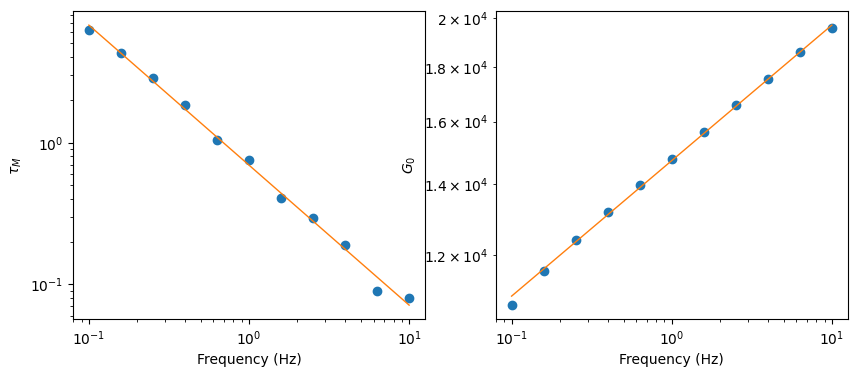

In [5]:
if runSAOS == 'yes':

        params_frfit_waveform = []
        obj_frfit_waveform = []
        for freq in freqvals_frfit:
                opt_par_wave, objfuncval_wave, result_wave= optimization_lin_perfreq_ruud(init_guess_lin, bounds_lin_norm, strain_lin, 
                        current_freq=freq, wholefreq=freqvals_frfit, cycles=cycles,ntimesteps_cycle=ntimesteps_cycle, col_index_stress=col_index_stress,\
                                all_data=data_exp_frswp_waveform_avg, nelements_cycle=nelements_cycle)

                params_frfit_waveform.append(opt_par_wave)
                obj_frfit_waveform.append(objfuncval_wave)



        #Find the expressions for G and tau
        mod_frfit = []
        trel_frfit = []   
        for paramset in params_frfit_waveform:
                mod_frfit.append(paramset[0])
                trel_frfit.append(paramset[1])

        tr_opt_lin, tr_conv_lin = curve_fit(linear, np.log10(freqvals_frfit), np.log10(trel_frfit))
        mod_opt, mod_conv = curve_fit(power_law, freqvals_frfit, mod_frfit)
        tr_opt = [10**tr_opt_lin[1], tr_opt_lin[0]]


        fig, axs = plt.subplots(1,2,figsize=(10, 4))
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].set_xlabel("Frequency (Hz)")

        axs[0].set_ylabel(r"$\tau_M$")
        axs[0].plot(freqvals_frfit, trel_frfit, marker='o', linewidth=0)
        axs[0].plot(freqvals_frfit, power_law(freqvals_frfit, tr_opt[0], tr_opt[1]), linewidth=1)

        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[1].set_xlabel("Frequency (Hz)")
        axs[1].set_ylabel(r"$G_0$")
        axs[1].plot(freqvals_frfit, mod_frfit, marker='o', linewidth=0)
        axs[1].plot(freqvals_frfit, power_law(freqvals_frfit, mod_opt[0], mod_opt[1]), linewidth=1)


        #Calculate the errorbars
        err_mod_freqvalfit = []
        err_trel_freqvalfit = []

        variation = np.linspace(0.05,10,500)        
        p= 2
        n= ntimesteps_cycle
        conf_int = 0.05
        F= stats.f.ppf(1 - conf_int, p, n)
        right_hand_side = (p / (n-p)) * F
        print(right_hand_side)

        for i in range(0,len(freqvals_frfit)):
                theta0 = params_frfit_waveform[i]
                freq = freqvals_frfit[i]
                for p in range(0,len(theta0)):    
                        for var in variation:
                                theta =  copy.deepcopy(theta0)
                                theta[p] = theta[p]*(1+var/100)

                                #calculate S
                                S = sum_of_squared_residuals_ruud(theta, freq, strain_lin,\
                                     freqvals_frfit, cycles,ntimesteps_cycle, col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate,\
                                     all_data=data_exp_frswp_waveform_avg, nelements_cycle=nelements_cycle )

                                left_hand_side = (S - obj_frfit_waveform[i]) / obj_frfit_waveform[i]

                                if left_hand_side > right_hand_side:
                                        print(f'freq:{freqvals_frfit[i]:2.2f}, param:{p} - percentage where 95% conf interval is exceeded: {var:2.2f}%')
                                        if p == 0:
                                                err_mod_freqvalfit.append(var)
                                        if p == 1:
                                                err_trel_freqvalfit.append(var)
                                        break

                                if var == variation[len(variation)-1]:
                                        print(f'increase the upper limit for variation for param {p}')

        print(err_mod_freqvalfit)
        write_out = ['params_frfit_waveform', 'obj_frfit_waveform',\
                      'tr_opt', 'mod_opt','trel_frfit', 'mod_frfit',\
                        'err_mod_freqvalfit','err_trel_freqvalfit']
        
        with open(f'checkpoints/SAOSfit_{formatted_time}_humanreadable.npz', 'w') as f:
                for var_name in dir():
                # Skip private/internal variables
                        if not var_name.startswith('_'):
                                var_value = eval(var_name)
                        
                        # Check if the variable is a NumPy array (or any other array-like type)
                        if isinstance(var_value, (np.ndarray, list)):

                                if var_name in write_out:
                                        # Write variable assignment to the file
                                        text1 = f'{var_name} = {repr(var_value)}'
                                        f.write(textwrap.fill(text1, width=80))
                                        f.write('\n')

        np.savez(f'checkpoints/SAOSfit_{formatted_time}.npz', **{name: eval(name) for name in write_out})
if runSAOS == 'no':

        #Load the data
        data = np.load(F'./checkpoints/{readSAOS}.npz', allow_pickle=True)
        array_names = data.files  # This returns a list of names
        for name in array_names:
                globals()[name] = data[name]   

        
        print(f'Parameters: \n{params_frfit_waveform} \n\n\
Obj Function Vals: {obj_frfit_waveform} \n\n\
Err mod perc: {err_mod_freqvalfit}\n\n\
Err trel perc:{err_trel_freqvalfit} \n\n\
                 ')
        
        fig, axs = plt.subplots(1,2,figsize=(10, 4))
        axs[0].set_xscale('log')
        axs[0].set_yscale('log')
        axs[0].set_xlabel("Frequency (Hz)")
        axs[0].set_ylabel(r"$\tau_M$")
        axs[0].plot(freqvals_frfit, trel_frfit, marker='o', linewidth=0)
        axs[0].plot(freqvals_frfit, power_law(freqvals_frfit, tr_opt[0], tr_opt[1]), linewidth=1)

        axs[1].set_xscale('log')
        axs[1].set_yscale('log')
        axs[1].set_xlabel("Frequency (Hz)")
        axs[1].set_ylabel(r"$G_0$")
        axs[1].plot(freqvals_frfit, mod_frfit, marker='o', linewidth=0)
        axs[1].plot(freqvals_frfit, power_law(freqvals_frfit, mod_opt[0], mod_opt[1]), linewidth=1)



Plot and check if predictied and exp match

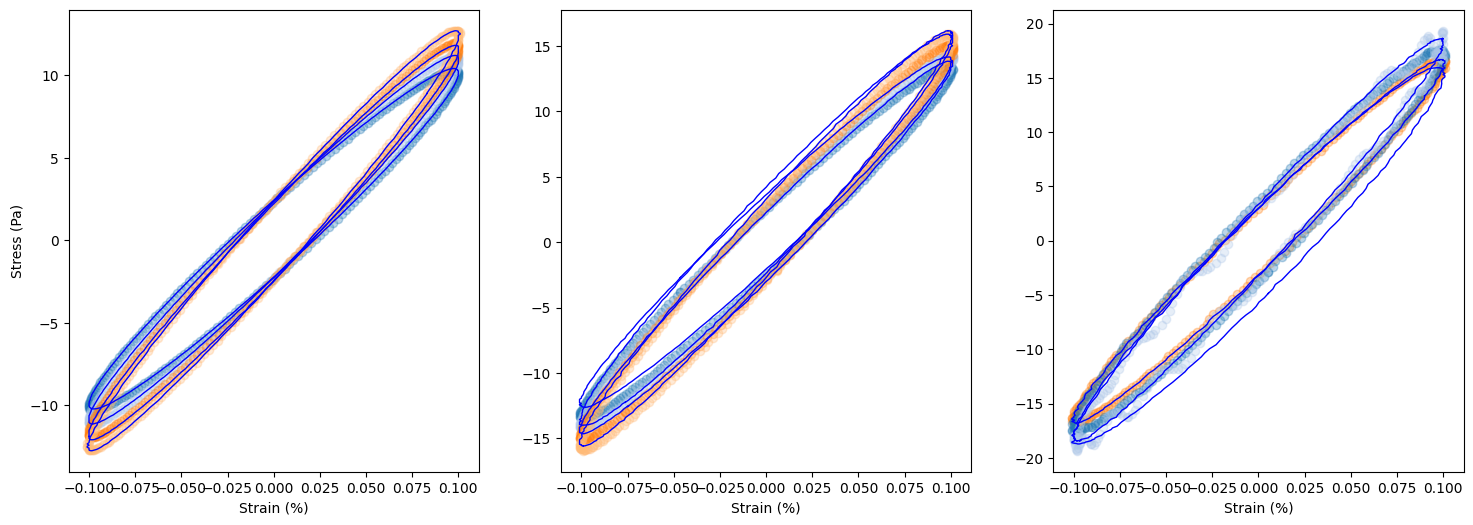

In [6]:
fig, axs = plt.subplots(1,3,figsize=(18, 6))

axs[0].set_xlabel('Strain (%)')
axs[1].set_xlabel('Strain (%)')
axs[2].set_xlabel('Strain (%)')
axs[0].set_ylabel("Stress (Pa)")

for i in range(0,len(freqvals_frfit)):
    x= np.multiply(data_exp_frswp_waveform_avg[0][0][col_index_strain][i*nelements_cycle:(i+1)*nelements_cycle],100)
    y= np.divide(data_exp_frswp_waveform_avg[0][0][col_index_stress][i*nelements_cycle:(i+1)*nelements_cycle],1)
   
    if i <= 3:
        axs[0].errorbar(x, y,\
             marker='o', linewidth=0, markersize=6, color=color_palette[i%4], ecolor=color_palette[i], elinewidth = 1,
             label=f'freq:{freqvals_frfit[i]}', alpha=0.3)
        
    elif i < 8:
        axs[1].errorbar(x,y,\
             marker='o', linewidth=0, markersize=6, color=color_palette[i%4], ecolor=color_palette[i%3], elinewidth = 1,
             label=f'freq:{freqvals_frfit[i]}',alpha=0.3)
        
    else:
        axs[2].errorbar(x, y,\
             marker='o', linewidth=0, markersize=6, color=color_palette[i%3], ecolor=color_palette[i%3], elinewidth = 1,
             label=f'freq:{freqvals_frfit[i]}',alpha=0.3)

gammadot_list =  data_exp_frswp_waveform_avg[0][0][col_index_shearrate]       
for i in range(0,len(freqvals_frfit)):
    x= np.multiply(data_exp_frswp_waveform_avg[0][0][col_index_strain][i*nelements_cycle:(i+1)*nelements_cycle],100)
    params = params_frfit_waveform[i]
    G1, G2, predsigma, time = pred_data = Ruud_Single_Cycle_Oldroydb(strain_lin,\
                      freqvals_frfit[i],params, cycles,ntimesteps_cycle, gammadot_list[i*nelements_cycle:(i+1)*nelements_cycle])
    if i <= 3:
        axs[0].errorbar(x, 
                  np.divide(predsigma[-nelements_cycle:], 1), linewidth=1, marker='o', color='blue', markersize =0)
    elif i < 8:
        axs[1].errorbar(x, 
                  np.divide(predsigma[-nelements_cycle:], 1), linewidth=1, marker='o', color='blue', markersize =0)
    else:
        axs[2].errorbar(x, 
                  np.divide(predsigma[-nelements_cycle:], 1), linewidth=1, marker='o', color='blue', markersize =0)
        
#ALSO PLOT G1 - G2

# LAOS Fitting

## With 5 Parameters Adjustment

In [8]:
if runLAOS == 'yes':
    #Perform the fitting
    opt_par_nonlin, objfuncval_nonlin, resultnonlin_nonlin = optimization_nonlin_together_ruud(init_guess_nonlin, bounds_nonlin_norm,
                    strain_values_nonlin, freqvals,cycles,eta_inf,ntimesteps_cycle,\
                    col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate,\
                    all_data=data_exp_avg, optimized_params_lin=[mod_opt, tr_opt],nelements_cycle=nelements_cycle )

    objfuncval_nonlin_array = [objfuncval_nonlin]

    #Convert the parameters to the actual values
    opt_par_all = []
    for m in range(0,len(opt_par_nonlin)):
        par = opt_par_nonlin[m]
        boun = bounds_nonlin_norm[m]
        newpar = par * (boun[1]-boun[0])+boun[0]

        if m==0 or m == 3 or m==4 :
            newpar = 10**(newpar)

        opt_par_all.append(newpar)
    print(f'Parameters:{opt_par_all}')


    #Calculate the errors
    variation = np.linspace(0.05,25,100)        
    p= 5
    n= nelements_cycle * len(strain_values_nonlin) 
    F= 2.21
    right_hand_side = (p / (n-p)) * F
    print(right_hand_side)

    error_allfitting_perc = []

    theta0 = opt_par_all
    for p in [0,1,2,3,4]:    
            for var in variation:
                theta =  copy.deepcopy(theta0)
                theta[p] = theta[p]*(1+var/100)

                #calculate S
                S = sum_of_squared_residuals_laos_ruud(theta, strain_values_nonlin, freqvals, cycles, eta_inf, ntimesteps_cycle,\
                                        col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate,\
                                        all_data=data_exp_avg, optimized_params_lin=[mod_opt, tr_opt], nelements_cycle=nelements_cycle  )

                left_hand_side = (S - objfuncval_nonlin) / objfuncval_nonlin
                #print(left_hand_side)

                if left_hand_side > right_hand_side:
                    print(f'param:{p} - percentage where 95% conf interval is exceeded: {var:2.2f}%')
                    error_allfitting_perc.append(var)
                    break

                if var == variation[len(variation)-1]:
                    print(f'increase the upper limit for variation for param {p}')

    # Write out to the file
    write_out = ['objfuncval_nonlin_array', 'opt_par_nonlin', 'opt_par_all', 'error_allfitting_perc' ]

    with open(f'checkpoints/LAOSfit_all_{formatted_time}_humanreadable.npz', 'w') as f:
            for var_name in dir():
            # Skip private/internal variables
                    if not var_name.startswith('_'):
                            var_value = eval(var_name)
                            
                    # Check if the variable is a NumPy array (or any other array-like type)
                    if isinstance(var_value, (np.ndarray, list)):

                            if var_name in write_out:
                                    # Write variable assignment to the file
                                    text1 = f'{var_name} = {repr(var_value)}'
                                    f.write(textwrap.fill(text1, width=80))
                                    f.write('\n')

    np.savez(f'checkpoints/LAOSfit_all_{formatted_time}.npz', **{name: eval(name) for name in write_out})

if runLAOS == 'no':
 
        #Load the data
        data = np.load(F'./checkpoints/{readLAOS}.npz', allow_pickle=True)
        array_names = data.files  # This returns a list of names
        for name in array_names:
                globals()[name] = data[name]   


                

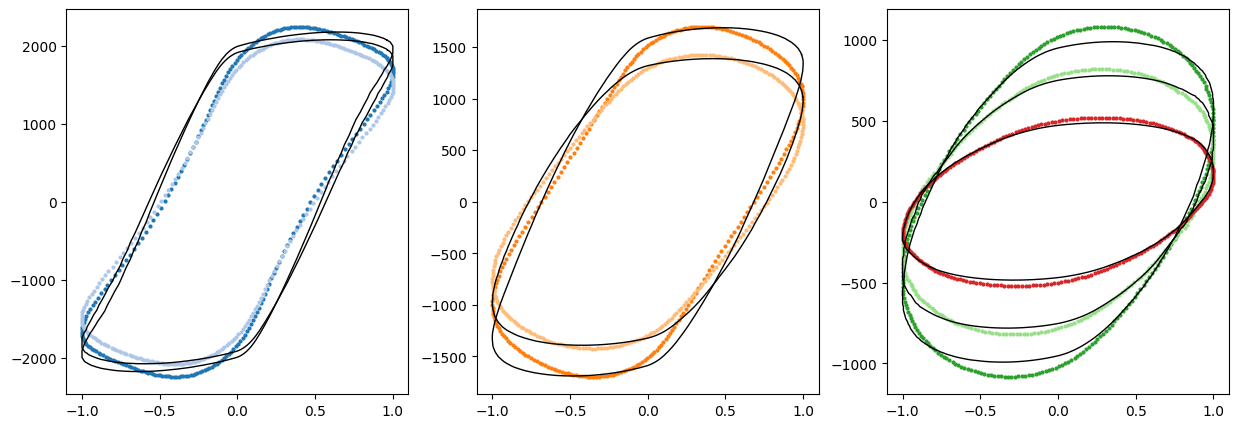

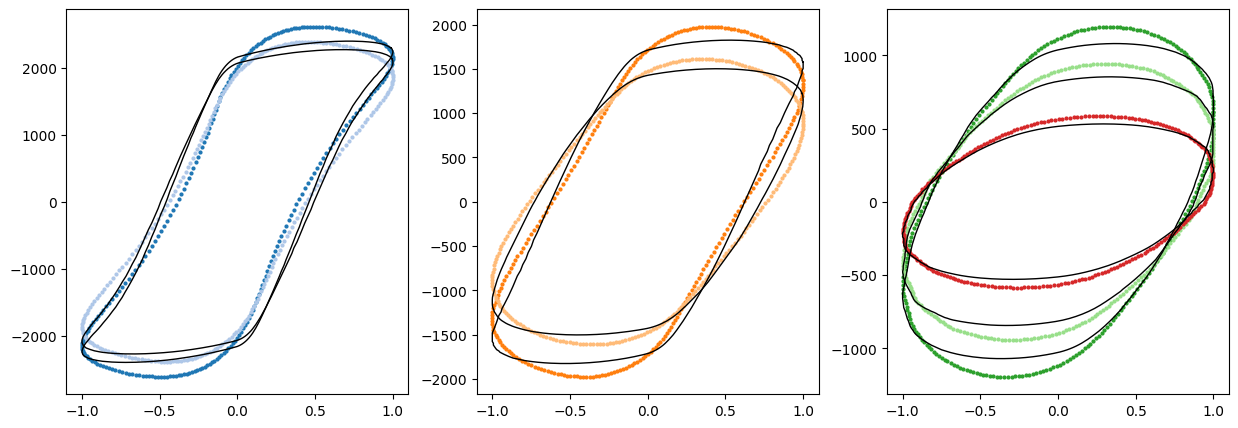

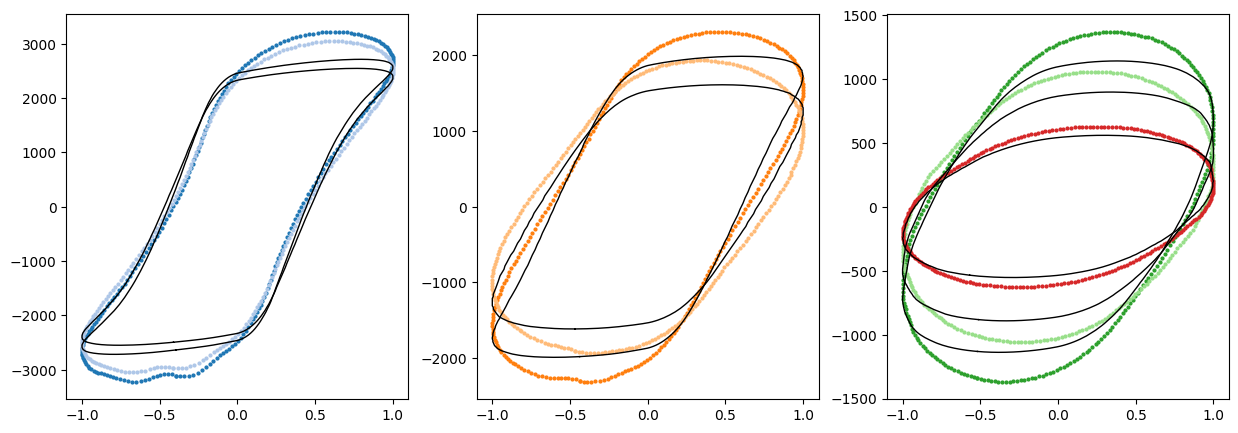

In [9]:
data_pred_all = []
freqindex = 0
for freqval in freqvals:
    
    modulus = mod_opt[0]*freqval**mod_opt[1]
    trel = tr_opt[0]*freqval**tr_opt[1]
    strain_index= 0
    for strainval in strain_values_nonlin:
        gammadot_data =data_exp_avg[strain_index+len(strain_values_nonlin)*freqindex][col_index_shearrate][-nelements_cycle:]
        G1, G2, data_pred, time = Ruud_Single_Cycle_Full(modulus, trel, freqval, strainval,\
                                                                opt_par_all, cycles, eta_inf,\
                                                            ntimesteps_cycle, gammadot_data, gammadot_howto='from data')
        data_pred_all.append(data_pred)
        strain_index+=1
    freqindex +=1

for k in range(0,len(freqvals)):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))

    for i in range(0,len(strain_values_nonlin)):
        x1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_shearrate][-nelements_cycle:]
        y1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_stress][-nelements_cycle:]

        if i < 2:
            # Plot data in the first subplot
            axs[0].plot(np.divide(x1,max(x1)), y1, marker='o', color=color_palette[i%len(strain_values_nonlin)], label='Data 1', markersize=2, linewidth =0)

        if 2 <= i < 4:
            # Plot data in the first subplot
            axs[1].plot(np.divide(x1,max(x1)), y1, marker='o', color=color_palette[i%len(strain_values_nonlin)], label='Data 1', markersize=2, linewidth =0)

        if  4 <= i:
            # Plot data in the first subplot
            axs[2].plot(np.divide(x1,max(x1)), y1, marker='o', color=color_palette[i%len(strain_values_nonlin)], label='Data 1', markersize=2, linewidth =0)

    for i in range(0,len(strain_values_nonlin)):
        x1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_shearrate][-nelements_cycle:]
        y1 = data_pred_all[i+k*len(strain_values_nonlin)][-nelements_cycle:]

        if i < 2:
            # Plot data in the first subplot
            axs[0].plot(np.divide(x1,max(x1)), y1, color='black', label='Data 1', markersize=2, linewidth =1)

        if 2 <= i < 4:
            # Plot data in the first subplot
            axs[1].plot(np.divide(x1,max(x1)), y1,color='black', label='Data 1', markersize=2, linewidth =1)

        if  4 <= i:
            # Plot data in the first subplot
            axs[2].plot(np.divide(x1,max(x1)), y1, color='black', label='Data 1', markersize=2, linewidth =1)

## With Herschel Bulkley Parameters Given

In [10]:
if 'HBparam_laos' in globals():
    opt_parHBlaos, objfuncvalHBlaos, resultnonlinHBlaos = optimization_nonlin_together_ruud_HB_given(initial_guess_nonlin=init_guess_hb, HBparam = HBparam_laos, \
                    bounds_nonlin_norm = bounds_nonlin_norm_hb,\
                    strain_values_nonlin=strain_values_nonlin,\
                    freq=freqvals,cycles=cycles,eta_inf=eta_inf,ntimesteps_cycle=ntimesteps_cycle,\
                    col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate,\
                    all_data=data_exp_avg,\
                    optimized_params_lin= [mod_opt, tr_opt], nelements_cycle=nelements_cycle)
    objfuncvalHBlaos_array = [objfuncvalHBlaos]

    opt_par_newlaos = []
    for m in range(0,len(opt_parHBlaos)):
        par = opt_parHBlaos[m]
        boun = bounds_nonlin_norm_hb[m]
        newpar = par * (boun[1]-boun[0])+boun[0]
        if m==1 :
            newpar = 10**(newpar)
        opt_par_newlaos.append(newpar)

    opt_par_HBgiven_laos = [HBparam_laos[0], HBparam_laos[1], opt_par_newlaos[0], HBparam_laos[2], opt_par_newlaos[1]]      
    print(opt_par_HBgiven_laos)

    variation = np.linspace(0.05,20,100)        
    
    p= 2
    n= nelements_cycle * len(strain_values_nonlin) 
    F= 3.00 #for 
    right_hand_side = (p / (n-p)) * F
    print(right_hand_side)

    error_HBLAOS_perc = []
    theta0 = opt_par_HBgiven_laos
    for p in [2,4]:    
            for var in variation:
                theta =  copy.deepcopy(theta0)
                theta[p] = theta[p]*(1+var/100)

                #calculate S
                S = sum_of_squared_residuals_laos_ruud(theta, strain_values_nonlin, freqvals, cycles, eta_inf, ntimesteps_cycle,\
                                        col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate, all_data=data_exp_avg,\
                                        optimized_params_lin=[mod_opt, tr_opt], nelements_cycle=nelements_cycle )

                left_hand_side = (S - objfuncvalHBlaos) / objfuncvalHBlaos

                if left_hand_side > right_hand_side:
                    print(f'param:{p} - percentage where 95% conf interval is exceeded: {var:2.2f}%')
                    error_HBLAOS_perc.append(var)
                    break

                if var == variation[len(variation)-1]:
                    print(f'increase the upper limit for variation for param {p}')

else: print('The stress growth infromation is not found in the file, take action if you think this is wrong')


if 'HBparam_steady' in globals():
    opt_parHBst, objfuncvalHBst, resultnonlinHBst = optimization_nonlin_together_ruud_HB_given(initial_guess_nonlin=init_guess_hb, HBparam = HBparam_steady, \
                        bounds_nonlin_norm = bounds_nonlin_norm_hb,\
                        strain_values_nonlin=strain_values_nonlin,\
                        freq=freqvals,cycles=cycles,eta_inf=eta_inf,ntimesteps_cycle=ntimesteps_cycle,\
                        col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate,\
                        all_data=data_exp_avg,\
                        optimized_params_lin= [mod_opt, tr_opt], nelements_cycle=nelements_cycle)
    objfuncvalHBst_array = [objfuncvalHBst]

    opt_par_newst = []
    for m in range(0,len(opt_parHBst)):
        par = opt_parHBst[m]
        boun = bounds_nonlin_norm_hb[m]
        newpar = par * (boun[1]-boun[0])+boun[0]
        if m==1 :
            newpar = 10**(newpar)
        opt_par_newst.append(newpar)

    opt_par_HBgiven_st = [HBparam_steady[0], HBparam_steady[1], opt_par_newst[0], HBparam_steady[2], opt_par_newst[1]]
    print(opt_par_HBgiven_st)

    error_HBST_perc = []
    theta0 = opt_par_HBgiven_st
    for p in [2,4]:    
            for var in variation:
                theta =  copy.deepcopy(theta0)
                theta[p] = theta[p]*(1+var/100)

                #calculate S
                S = sum_of_squared_residuals_laos_ruud(theta, strain_values_nonlin, freqvals, cycles, eta_inf, ntimesteps_cycle,\
                                        col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate, all_data=data_exp_avg,\
                                        optimized_params_lin=[mod_opt, tr_opt], nelements_cycle=nelements_cycle )

                left_hand_side = (S - objfuncvalHBst) / objfuncvalHBst

                if left_hand_side > right_hand_side:
                    print(f'param:{p} - percentage where 95% conf interval is exceeded: {var:2.2f}%')
                    error_HBST_perc.append(var)
                    break

                if var == variation[len(variation)-1]:
                    print(f'increase the upper limit for variation for param {p}')


else: print('The stress growth infromation is not found in the file, take action if you think this is wrong')


#External
if 'HBparam_ext' in globals():
    opt_parHBext, objfuncvalHBext, resultnonlinHBext = optimization_nonlin_together_ruud_HB_given(initial_guess_nonlin=init_guess_hb, HBparam = HBparam_ext, \
                        bounds_nonlin_norm = bounds_nonlin_norm_hb,\
                        strain_values_nonlin=strain_values_nonlin,\
                        freq=freqvals,cycles=cycles,eta_inf=eta_inf,ntimesteps_cycle=ntimesteps_cycle,\
                        col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate,\
                        all_data=data_exp_avg,\
                        optimized_params_lin= [mod_opt, tr_opt], nelements_cycle=nelements_cycle)
    objfuncvalHBext_array = [objfuncvalHBext]

    opt_par_newext = []
    for m in range(0,len(opt_parHBext)):
        par = opt_parHBext[m]
        boun = bounds_nonlin_norm_hb[m]
        newpar = par * (boun[1]-boun[0])+boun[0]
        if m==1 :
            newpar = 10**(newpar)
        opt_par_newext.append(newpar)

    opt_par_HBgiven_ext = [HBparam_ext[0], HBparam_ext[1], opt_par_newext[0], HBparam_ext[2], opt_par_newext[1]]
    print(opt_par_HBgiven_ext)

    error_HBext_perc = []
    theta0 = opt_par_HBgiven_ext
    for p in [2,4]:    
            for var in variation:
                theta =  copy.deepcopy(theta0)
                theta[p] = theta[p]*(1+var/100)

                #calculate S
                S = sum_of_squared_residuals_laos_ruud(theta, strain_values_nonlin, freqvals, cycles, eta_inf, ntimesteps_cycle,\
                                        col_index_stress=col_index_stress, col_index_shearrate=col_index_shearrate, all_data=data_exp_avg,\
                                        optimized_params_lin=[mod_opt, tr_opt], nelements_cycle=nelements_cycle )

                left_hand_side = (S - objfuncvalHBext) / objfuncvalHBext

                if left_hand_side > right_hand_side:
                    print(f'param:{p} - percentage where 95% conf interval is exceeded: {var:2.2f}%')
                    error_HBext_perc.append(var)
                    break

                if var == variation[len(variation)-1]:
                    print(f'increase the upper limit for variation for param {p}')


else: print('The external HB infromation is not found in the file, take action if you think this is wrong')





Minimization is finished successfully for the non-linear region
[1001.3794899497004, 0.3024060656589302, 0.3370356358560127, 2.600346731143198, 0.026242057680362346]
0.00333889816360601
param:2 - percentage where 95% conf interval is exceeded: 3.27%
param:4 - percentage where 95% conf interval is exceeded: 6.30%
Minimization is finished successfully for the non-linear region
[847.4029589060317, 0.28664606824972405, 0.40468502951929874, 0.13569066249805056, 0.023091284811939457]
param:2 - percentage where 95% conf interval is exceeded: 2.27%
param:4 - percentage where 95% conf interval is exceeded: 5.69%
Minimization is finished successfully for the non-linear region
[1000.0, 0.2, 0.32465666820012873, 10.0, 0.027433964683182127]
param:2 - percentage where 95% conf interval is exceeded: 6.30%
param:4 - percentage where 95% conf interval is exceeded: 10.53%


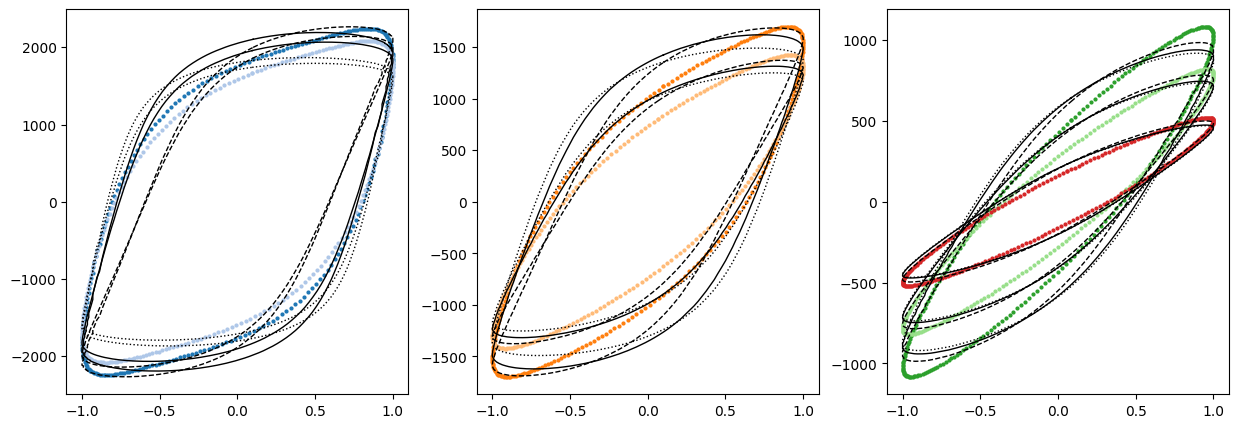

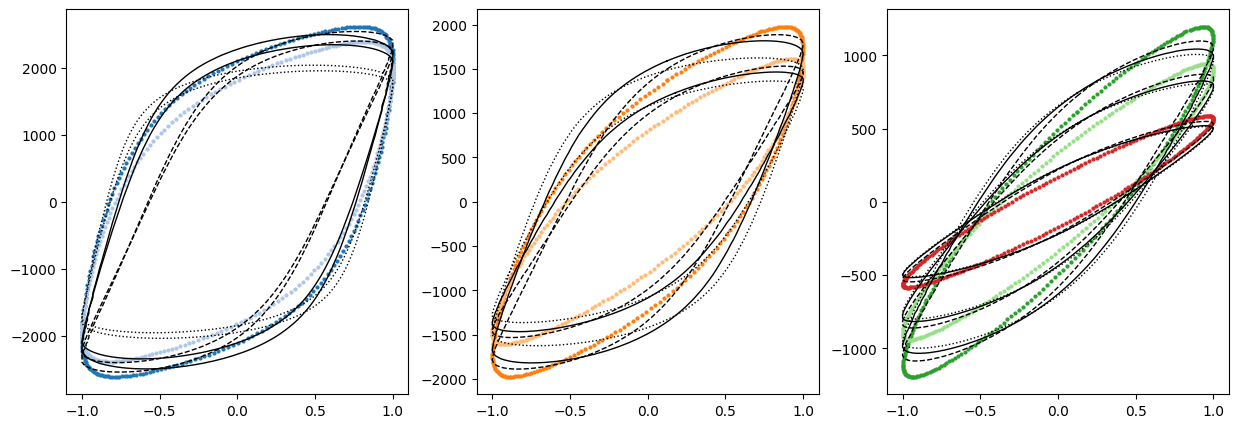

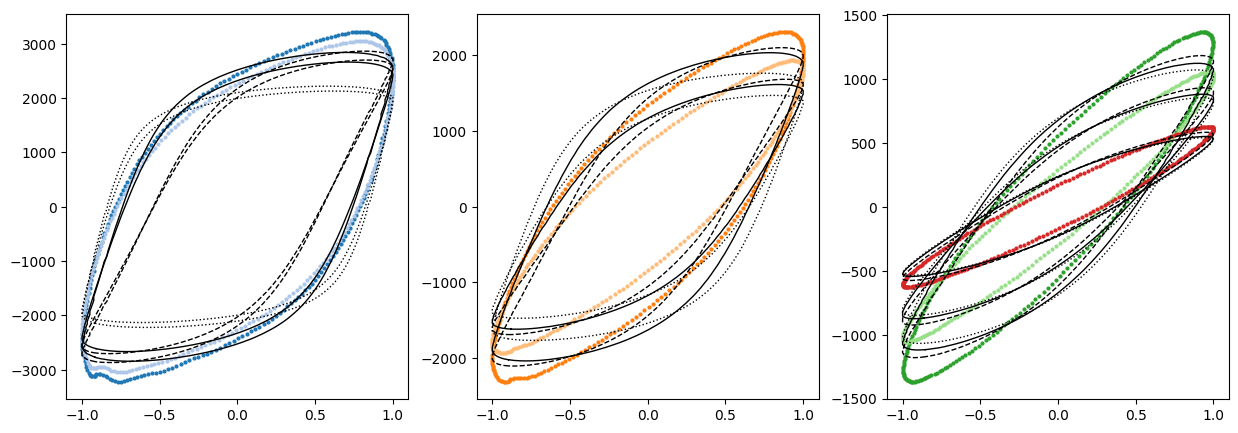

In [11]:
for k in range(0,len(freqvals)):
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    freqval = freqvals[k]

    modulus = mod_opt[0]*freqval**mod_opt[1]
    trel = tr_opt[0]*freqval**tr_opt[1]

    for i in range(0,len(strain_values_nonlin)):
        x1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_strain][-nelements_cycle:]
        y1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_stress][-nelements_cycle:]

        if i < 2:
            # Plot data in the first subplot
            axs[0].plot(np.divide(x1,max(x1)), y1, marker='o', color=color_palette[i%len(strain_values_nonlin)], label='Data 1', markersize=2, linewidth =0)

        if 2 <= i < 4:
            # Plot data in the first subplot
            axs[1].plot(np.divide(x1,max(x1)), y1, marker='o', color=color_palette[i%len(strain_values_nonlin)], label='Data 1', markersize=2, linewidth =0)

        if  4 <= i:
            # Plot data in the first subplot
            axs[2].plot(np.divide(x1,max(x1)), y1, marker='o', color=color_palette[i%len(strain_values_nonlin)], label='Data 1', markersize=2, linewidth =0)
    
    if 'HBparam_laos' in globals():
        for i in range(0,len(strain_values_nonlin)):
            x1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_strain][-nelements_cycle:]
            G1, G2, y1, time = Ruud_Single_Cycle_Full(modulus, trel, freqval,  strain_values_nonlin[i], opt_par_HBgiven_laos,cycles,\
                        eta_inf, ntimesteps_cycle,  gammadot_data=data_exp_avg[i+k*len(strain_values_nonlin)][col_index_shearrate][-nelements_cycle:],\
                        gammadot_howto='from data')
            
            if i < 2:
                # Plot data in the first subplot
                axs[0].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:], color='black', label='Data 1', markersize=2, linewidth =1)

            if 2 <= i < 4:
                # Plot data in the first subplot
                axs[1].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:],color='black', label='Data 1', markersize=2, linewidth =1)

            if  4 <= i:
                # Plot data in the first subplot
                axs[2].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:], color='black', label='Data 1', markersize=2, linewidth =1)

    if 'HBparam_steady' in globals():
        for i in range(0,len(strain_values_nonlin)):
            x1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_strain][-nelements_cycle:]
            G1, G2, y1, time = Ruud_Single_Cycle_Full(modulus, trel, freqval,  strain_values_nonlin[i], opt_par_HBgiven_st,cycles,\
                        eta_inf, ntimesteps_cycle,  gammadot_data=data_exp_avg[i+k*len(strain_values_nonlin)][col_index_shearrate][-nelements_cycle:],\
                        gammadot_howto='from data')

            if i < 2:
                # Plot data in the first subplot
                axs[0].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:], color='black', label='Data 1', markersize=2, linewidth =1, linestyle='--')

            if 2 <= i < 4:
                # Plot data in the first subplot
                axs[1].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:],color='black', label='Data 1', markersize=2, linewidth =1, linestyle='--')

            if  4 <= i:
                # Plot data in the first subplot
                axs[2].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:], color='black', label='Data 1', markersize=2, linewidth =1, linestyle='--')

    if 'HBparam_ext' in globals():
        for i in range(0,len(strain_values_nonlin)):
            x1 = data_exp_avg[i+k*len(strain_values_nonlin)][col_index_strain][-nelements_cycle:]
            G1, G2, y1, time = Ruud_Single_Cycle_Full(modulus, trel, freqval,  strain_values_nonlin[i], opt_par_HBgiven_ext,cycles,\
                        eta_inf, ntimesteps_cycle,  gammadot_data=data_exp_avg[i+k*len(strain_values_nonlin)][col_index_shearrate][-nelements_cycle:],\
                        gammadot_howto='from data')

            if i < 2:
                # Plot data in the first subplot
                axs[0].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:], color='black', label='Data 1', markersize=2, linewidth =1, linestyle=':')

            if 2 <= i < 4:
                # Plot data in the first subplot
                axs[1].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:],color='black', label='Data 1', markersize=2, linewidth =1, linestyle=':')

            if  4 <= i:
                # Plot data in the first subplot
                axs[2].plot(np.divide(x1,max(x1)), y1[-nelements_cycle:], color='black', label='Data 1', markersize=2, linewidth =1, linestyle=':')





# Plotting the Data with Predictions

## Steady Shearing 

In [12]:
model_steady_all = []
model_steady_all_last = []

if 'HBparam_laos' in globals():
    model_steady_laos = []
    model_steady_laos_last = []

if 'HBparam_steady' in globals():
    model_steady_st = []
    model_steady_st_last = []

if 'HBparam_ext' in globals():
    model_steady_ext = []
    model_steady_ext_last = []


for freqval in freqvals:
    modulus = (mod_opt[0]*freqval**mod_opt[1])
    trel = (tr_opt[0]*freqval**tr_opt[1]) 
    
    model_steady_last_freq = []
    model_steady_all_freq = []
    for gammadot in shear_rate_vals:

        stress_steady, time = Ruud_Steady( G=modulus, tau_M=trel, params=opt_par_all, eta_w=eta_inf, ntimesteps=ntimesteps_steady, gammadot=gammadot)
        model_steady_all_freq.append([time, stress_steady])
        model_steady_last_freq.append(stress_steady[-1])

    model_steady_all_last.append(model_steady_last_freq)
    model_steady_all.append(model_steady_all_freq)


    if 'HBparam_laos' in globals():
        model_steady_last_freq = []
        model_steady_all_freq = []
        for gammadot in shear_rate_vals:

            stress_steady, time = Ruud_Steady( G=modulus, tau_M=trel, params=opt_par_HBgiven_laos, eta_w=eta_inf, ntimesteps=ntimesteps_steady, gammadot=gammadot)
            model_steady_all_freq.append([time, stress_steady])
            model_steady_last_freq.append(stress_steady[-1])

        model_steady_laos_last.append(model_steady_last_freq)
        model_steady_laos.append(model_steady_all_freq)

    if 'HBparam_steady' in globals():
        model_steady_last_freq = []
        model_steady_all_freq = []
        for gammadot in shear_rate_vals:

            stress_steady, time = Ruud_Steady( G=modulus, tau_M=trel, params=opt_par_HBgiven_st, eta_w=eta_inf, ntimesteps=ntimesteps_steady, gammadot=gammadot)
            model_steady_all_freq.append([time, stress_steady])
            model_steady_last_freq.append(stress_steady[-1])

        model_steady_st_last.append(model_steady_last_freq)
        model_steady_st.append(model_steady_all_freq)

    if 'HBparam_ext' in globals():
        model_steady_last_freq = []
        model_steady_all_freq = []
        for gammadot in shear_rate_vals:

            stress_steady, time = Ruud_Steady( G=modulus, tau_M=trel, params=opt_par_HBgiven_ext, eta_w=eta_inf, ntimesteps=ntimesteps_steady, gammadot=gammadot)
            model_steady_all_freq.append([time, stress_steady])
            model_steady_last_freq.append(stress_steady[-1])

        model_steady_ext_last.append(model_steady_last_freq)
        model_steady_ext.append(model_steady_all_freq)



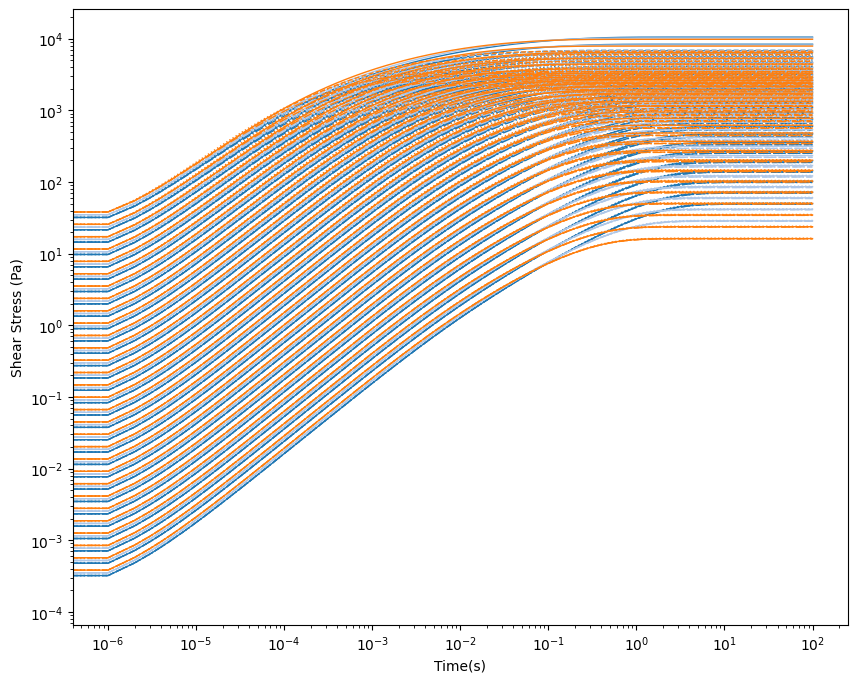

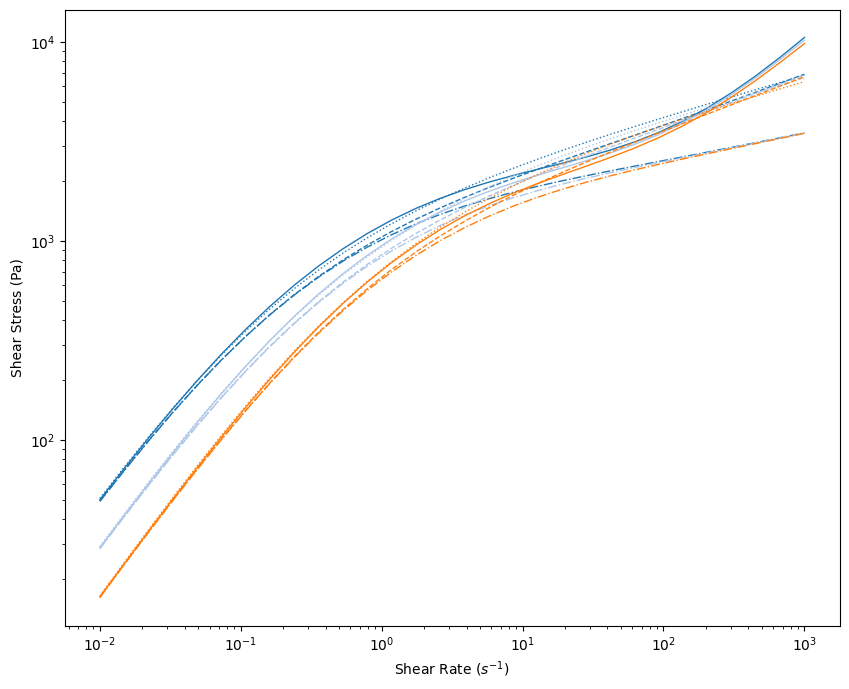

In [13]:
fig, ax = plt.subplots( figsize=(10,8))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time(s)')
ax.set_ylabel('Shear Stress (Pa)')
for freqindex in range(0,len(freqvals)):
        for shearrate in range(0,len(shear_rate_vals)):

                x =     model_steady_all[freqindex][shearrate][0]
                y_all = model_steady_all[freqindex][shearrate][1]
                ax.errorbar(x, y_all, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle='-')


                if 'HBparam_laos' in globals():
                        x = model_steady_laos[freqindex][shearrate][0]
                        y = model_steady_laos[freqindex][shearrate][1]

                        ax.errorbar(x, y, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle='--')

                if 'HBparam_steady' in globals():
                        x = model_steady_st[freqindex][shearrate][0]
                        y = model_steady_st[freqindex][shearrate][1]

                        ax.errorbar(x, y, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle=':')
                
                if 'HBparam_ext' in globals():
                        x = model_steady_ext[freqindex][shearrate][0]
                        y = model_steady_ext[freqindex][shearrate][1]

                        ax.errorbar(x, y, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle='-.')


fig, ax = plt.subplots( figsize=(10,8))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Shear Rate ($s^{-1}$)')
ax.set_ylabel('Shear Stress (Pa)')
for freqindex in range(0,len(freqvals)):

                x =     shear_rate_vals
                y_all = model_steady_all_last[freqindex]
                ax.errorbar(x, y_all, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle='-')
                
                if 'HBparam_laos' in globals():
                        y = model_steady_laos_last[freqindex]

                        ax.errorbar(x, y, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle='--')

                if 'HBparam_steady' in globals():
                        y = model_steady_st_last[freqindex]

                        ax.errorbar(x, y, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle=':')
                
                if 'HBparam_ext' in globals():
                        y = model_steady_ext_last[freqindex]

                        ax.errorbar(x, y, xerr=None, yerr=None, label=None,\
                                color=color_palette[freqindex],\
                        linewidth=1, marker='o', markersize=0, alpha=1, linestyle='-.')

## Osicllatory Shearing

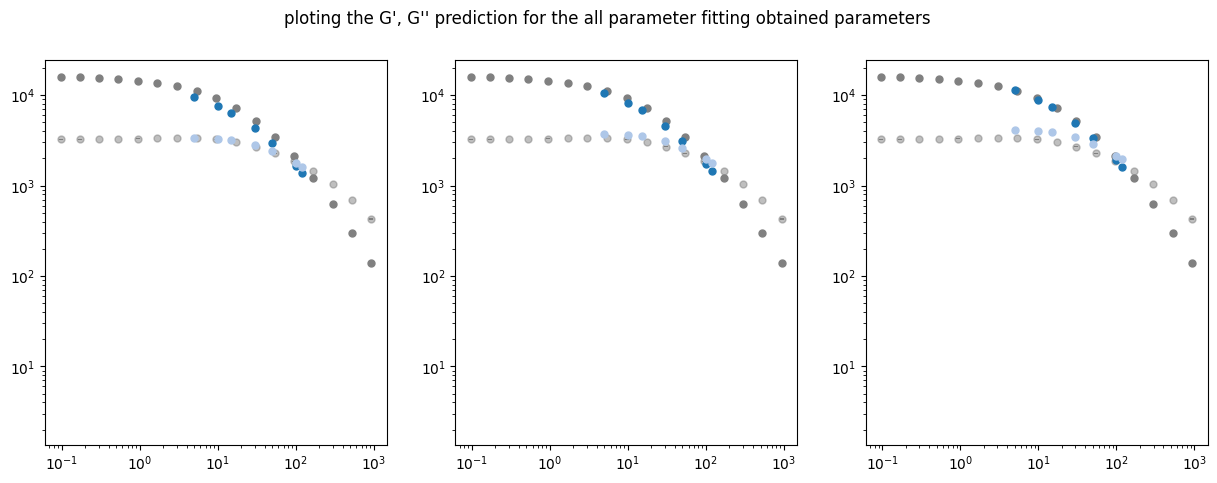

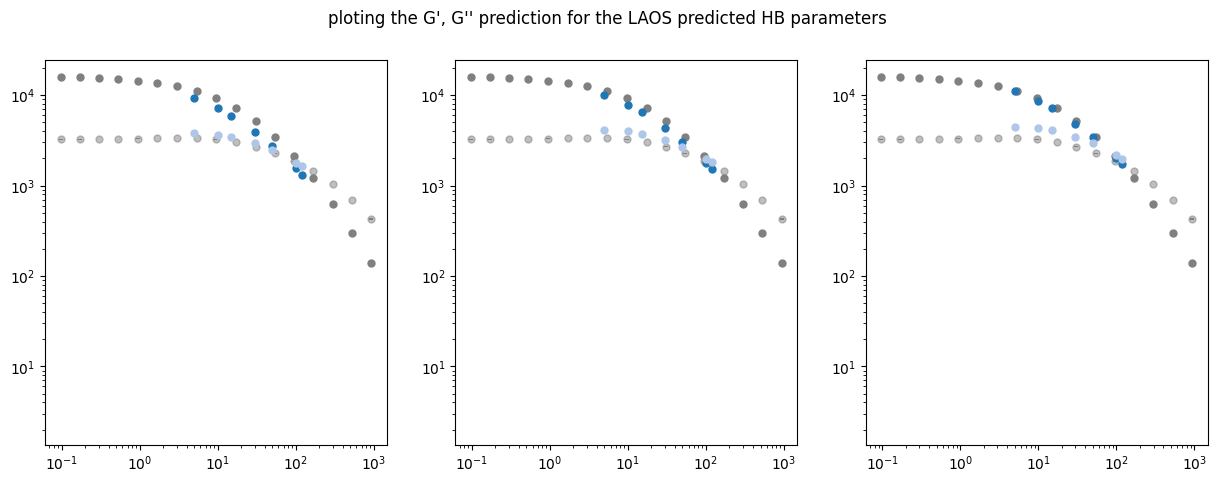

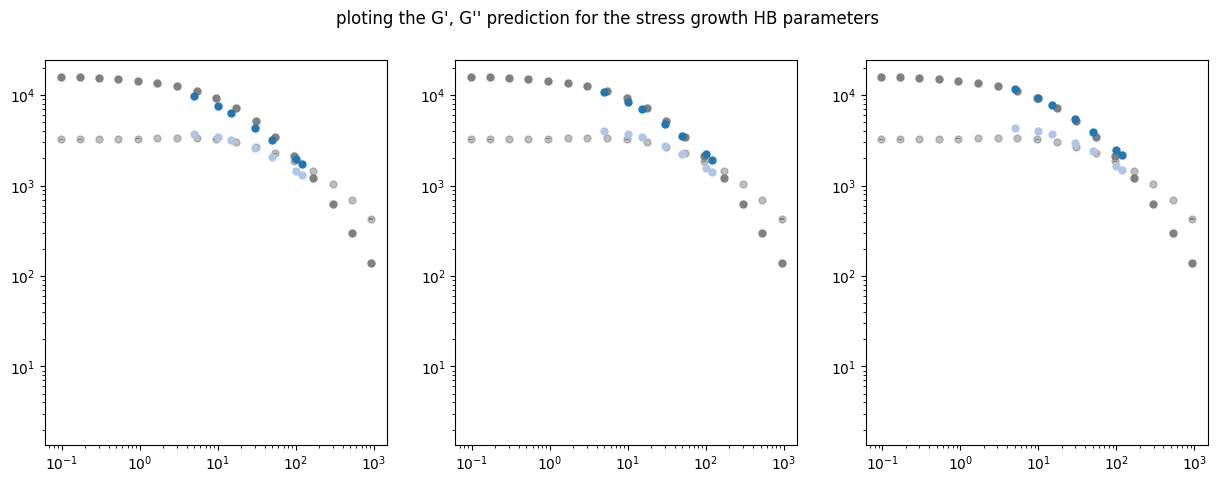

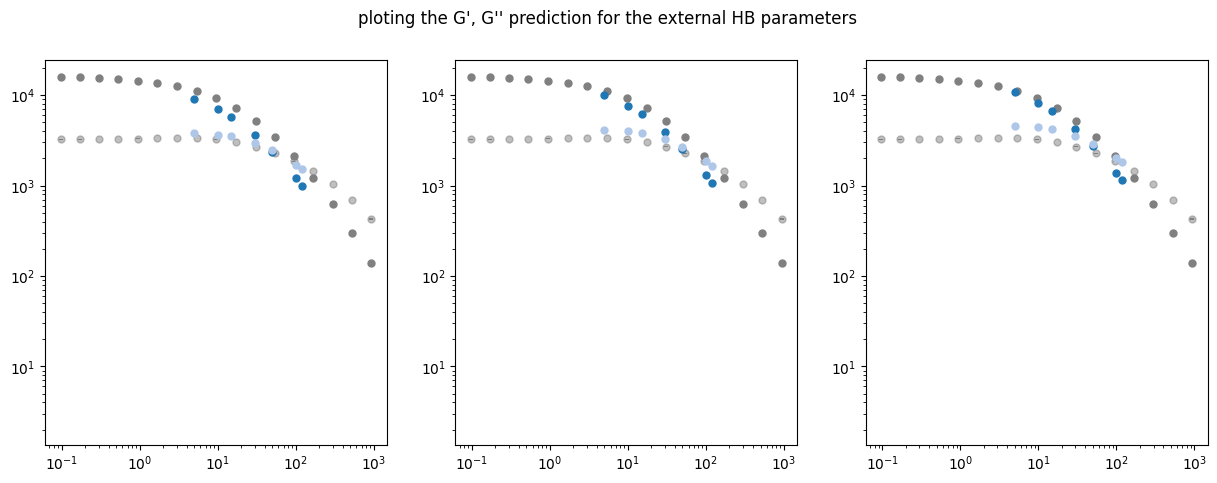

In [14]:
data_pred_G1 = []
data_pred_G2 = []
freqindex = 0
for freqval in freqvals:
    modulus = mod_opt[0]*freqval**mod_opt[1]
    trel = tr_opt[0]*freqval**tr_opt[1]
    
    strain_index= 0
    G1_freq = []
    G2_freq = []
    for strainval in strain_values_nonlin:
        gammadot_data =data_exp_avg[strain_index+len(strain_values_nonlin)*freqindex][col_index_shearrate][-nelements_cycle:]
        G1, G2, data_pred, time = Ruud_Single_Cycle_Full(modulus, trel, freqval, strainval,\
                                                                opt_par_all, cycles, eta_inf,\
                                                            ntimesteps_cycle, gammadot_data, gammadot_howto='from calculation')
        G1_freq.append(G1[-1])
        G2_freq.append(G2[-1])
        strain_index+=1   
        
    data_pred_G1.append(G1_freq)
    data_pred_G2.append(G2_freq)
 
    freqindex +=1


fig, axs = plt.subplots(1,3, figsize=(15, 5))
fig.suptitle("ploting the G', G'' prediction for the all parameter fitting obtained parameters")
for k in range(0,len(freqvals)):

        axs[k].set_xscale('log')
        axs[k].set_yscale('log')

        axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][1], yerr=std_str_swp[0], marker='o', color='gray',\
              label='exp', markersize=5, linewidth =0, ecolor = 'black', elinewidth=3)
        axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][2], yerr=std_str_swp[1], marker='o', color='gray',\
              label=None, markersize=5, linewidth =0, ecolor = 'black', elinewidth=3, alpha=0.5)

        axs[k].errorbar(strain_values_perc_nonlin, data_pred_G1[k], marker='o', \
                                  color=color_palette[0], label='Data 1', markersize=5, linewidth =0)
        axs[k].errorbar(strain_values_perc_nonlin, data_pred_G2[k], marker='o', \
                                  color=color_palette[1], label='Data 1', markersize=5, linewidth =0)
        

if 'HBparam_laos' in globals():
    data_pred_G1 = []
    data_pred_G2 = []
    freqindex = 0
    for freqval in freqvals:
        modulus = mod_opt[0]*freqval**mod_opt[1]
        trel = tr_opt[0]*freqval**tr_opt[1]
        
        strain_index= 0
        G1_freq = []
        G2_freq = []
        for strainval in strain_values_nonlin:
            gammadot_data =data_exp_avg[strain_index+len(strain_values_nonlin)*freqindex][col_index_shearrate][-nelements_cycle:]
            G1, G2, data_pred, time = Ruud_Single_Cycle_Full(modulus, trel, freqval, strainval,\
                                                                    opt_par_HBgiven_laos, cycles, eta_inf,\
                                                                ntimesteps_cycle, gammadot_data, gammadot_howto='from calculation')
            G1_freq.append(G1[-1])
            G2_freq.append(G2[-1])
            strain_index+=1   
            
        data_pred_G1.append(G1_freq)
        data_pred_G2.append(G2_freq)
    
        freqindex +=1
    
    
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    fig.suptitle("ploting the G', G'' prediction for the LAOS predicted HB parameters")
    for k in range(0,len(freqvals)):

            axs[k].set_xscale('log')
            axs[k].set_yscale('log')

            axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][1], yerr=std_str_swp[0], marker='o', color='gray',\
                label='exp', markersize=5, linewidth =0, ecolor = 'black', elinewidth=3)
            axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][2], yerr=std_str_swp[1], marker='o', color='gray',\
                label=None, markersize=5, linewidth =0, ecolor = 'black', elinewidth=3, alpha=0.5)

            axs[k].errorbar(strain_values_perc_nonlin, data_pred_G1[k], marker='o', \
                                    color=color_palette[0], label='Data 1', markersize=5, linewidth =0)
            axs[k].errorbar(strain_values_perc_nonlin, data_pred_G2[k], marker='o', \
                                    color=color_palette[1], label='Data 1', markersize=5, linewidth =0)
 
if 'HBparam_steady' in globals():
    data_pred_G1 = []
    data_pred_G2 = []
    freqindex = 0
    for freqval in freqvals:
        modulus = mod_opt[0]*freqval**mod_opt[1]
        trel = tr_opt[0]*freqval**tr_opt[1]
        
        strain_index= 0
        G1_freq = []
        G2_freq = []
        for strainval in strain_values_nonlin:
            gammadot_data =data_exp_avg[strain_index+len(strain_values_nonlin)*freqindex][col_index_shearrate][-nelements_cycle:]
            G1, G2, data_pred, time = Ruud_Single_Cycle_Full(modulus, trel, freqval, strainval,\
                                                                    opt_par_HBgiven_st, cycles, eta_inf,\
                                                                ntimesteps_cycle, gammadot_data, gammadot_howto='from calculation')
            G1_freq.append(G1[-1])
            G2_freq.append(G2[-1])
            strain_index+=1   
            
        data_pred_G1.append(G1_freq)
        data_pred_G2.append(G2_freq)
    
        freqindex +=1
    
    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    fig.suptitle("ploting the G', G'' prediction for the stress growth HB parameters")
    for k in range(0,len(freqvals)):

            axs[k].set_xscale('log')
            axs[k].set_yscale('log')

            axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][1], yerr=std_str_swp[0], marker='o', color='gray',\
                label='exp', markersize=5, linewidth =0, ecolor = 'black', elinewidth=3)
            axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][2], yerr=std_str_swp[1], marker='o', color='gray',\
                label=None, markersize=5, linewidth =0, ecolor = 'black', elinewidth=3, alpha=0.5)

            axs[k].errorbar(strain_values_perc_nonlin, data_pred_G1[k], marker='o', \
                                    color=color_palette[0], label='Data 1', markersize=5, linewidth =0)
            axs[k].errorbar(strain_values_perc_nonlin, data_pred_G2[k], marker='o', \
                                    color=color_palette[1], label='Data 1', markersize=5, linewidth =0)


if 'HBparam_ext' in globals():
    data_pred_G1 = []
    data_pred_G2 = []
    freqindex = 0
    for freqval in freqvals:
        modulus = mod_opt[0]*freqval**mod_opt[1]
        trel = tr_opt[0]*freqval**tr_opt[1]
        
        strain_index= 0
        G1_freq = []
        G2_freq = []
        for strainval in strain_values_nonlin:
            gammadot_data =data_exp_avg[strain_index+len(strain_values_nonlin)*freqindex][col_index_shearrate][-nelements_cycle:]
            G1, G2, data_pred, time = Ruud_Single_Cycle_Full(modulus, trel, freqval, strainval,\
                                                                    opt_par_HBgiven_ext, cycles, eta_inf,\
                                                                ntimesteps_cycle, gammadot_data, gammadot_howto='from calculation')
            G1_freq.append(G1[-1])
            G2_freq.append(G2[-1])
            strain_index+=1   
            
        data_pred_G1.append(G1_freq)
        data_pred_G2.append(G2_freq)
    
        freqindex +=1

    fig, axs = plt.subplots(1,3, figsize=(15, 5))
    fig.suptitle("ploting the G', G'' prediction for the external HB parameters")
    for k in range(0,len(freqvals)):

            axs[k].set_xscale('log')
            axs[k].set_yscale('log')

            axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][1], yerr=std_str_swp[0], marker='o', color='gray',\
                label='exp', markersize=5, linewidth =0, ecolor = 'black', elinewidth=3)
            axs[k].errorbar(data_exp_strswp_avg[0][0], data_exp_strswp_avg[0][2], yerr=std_str_swp[1], marker='o', color='gray',\
                label=None, markersize=5, linewidth =0, ecolor = 'black', elinewidth=3, alpha=0.5)

            axs[k].errorbar(strain_values_perc_nonlin, data_pred_G1[k], marker='o', \
                                    color=color_palette[0], label='Data 1', markersize=5, linewidth =0)
            axs[k].errorbar(strain_values_perc_nonlin, data_pred_G2[k], marker='o', \
                                    color=color_palette[1], label='Data 1', markersize=5, linewidth =0)
        
        
